# Imports

#### PyTorch imports

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim

In [2]:
print('PyTorch version', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

PyTorch version 2.5.1
Device: cuda


#### General imports

In [12]:
import os
import json
import math
import time
import random
from pathlib import Path
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

#### Monai imports

In [13]:
from monai.losses import DiceLoss, FocalLoss

# Parameters

#### Directories for the images

In [5]:
parent = Path().cwd().parent
data_root = parent / 'try_1'

train_images_dir = data_root / 'train' / 'images'
train_masks_dir = data_root / 'train' / 'masks'

val_images_dir = data_root / 'val' / 'images'
val_masks_dir = data_root / 'val' / 'masks'

#### General parameters

In [6]:
IMG_HEIGHT = 768
IMG_WIDTH = 768

BATCH_SIZE = 4

EPOCHS = 100
print('Number of epochs:', EPOCHS)

LR = 0.01
print('Learning rate:', LR)

"""
0 : background (black)
1 : arteries (white)
2 : veins (gray)
"""
NUM_CLASSES = 3

COLOR_TO_LABEL = {
    (0,0,0): 0,
    (255,255,255): 1,
    (128,128,128): 2
}

Number of epochs: 100
Learning rate: 0.01


#### Seed

In [9]:
# s = 42

In [10]:
def set_seed(s) :
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

# DataLoaders

#### Create the class for the dataset images

In [7]:
class RAVIRDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH), transforms=None):
        self.img_paths = sorted(list(Path(img_dir).glob('*.png')))
        self.mask_dir = Path(mask_dir)
        self.img_size = img_size
        self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_p = self.img_paths[idx]
        mask_p = self.mask_dir / img_p.name
        img = Image.open(img_p).convert('RGB').resize(self.img_size, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.transpose(img, (2,0,1))  # C,H,W
        img_t = torch.from_numpy(img).float()
        # load mask and map colors to labels
        m = Image.open(mask_p).convert('RGB').resize(self.img_size, Image.NEAREST)
        m_arr = np.array(m, dtype=np.uint8)
        label = np.zeros((self.img_size[1], self.img_size[0]), dtype=np.uint8)
        for color, lab in COLOR_TO_LABEL.items():
            mask = np.all(m_arr == np.array(color, dtype=np.uint8), axis=-1)
            label[mask] = lab
        label_t = torch.from_numpy(label).long()  # H,W
        return img_t, label_t

#### Actually create the datasets

In [8]:
train_ds = RAVIRDataset(train_images_dir, train_masks_dir, (IMG_WIDTH, IMG_HEIGHT))
val_ds = RAVIRDataset(val_images_dir, val_masks_dir, (IMG_WIDTH, IMG_HEIGHT))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# UNet Model V1 (not working)

![Image de l'architecture UNet](unet.png)

#### Conv 3x3, ReLU

In [8]:
def DoubleConv(in_ch, out_ch) :
    """
    Creates a bloc :
        Conv 3x3 -> ReLU -> Conv 3x3 -> ReLU
    """
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

#### Max pool 2x2

In [9]:
def down_block(in_ch, out_ch) :
    """
    Encoder bloc : 
        DoubleConv -> MaxPool 2x2
    """
    return nn.Sequential(
        DoubleConv(in_ch, out_ch),
        nn.MaxPool2d(kernel_size=2)
    )

#### Exemple

In [10]:
x = torch.randn(1, 1, 768, 768)

encode1 = down_block(1, 64)
y = encode1(x)

print(x.shape)
print(y.shape)

torch.Size([1, 1, 768, 768])
torch.Size([1, 64, 384, 384])


#### Bottleneck

In [11]:
def bottleneck(in_ch, out_ch) :
    """
    Central part of UNet
    """
    return DoubleConv(in_ch, out_ch)

#### UpSampling

In [12]:
def up_block(in_ch, out_ch) :
    """
    Decoder bloc :
        UpConv 2x2 -> Concatenate -> DoubleConv
    """
    return nn.Sequential(
        nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
        DoubleConv(in_ch, out_ch)
    )

In [13]:
def forward_up(block, x, skip_x):
    """
    Forward step for the upsampling block in UNet.
    - block: contains 'up' (ConvTranspose2d) and 'conv' (double_conv module)
    - x: feature map coming from the previous decoder step (or bottleneck)
    - skip_x: feature map from the corresponding encoder layer (skip connection)
    """
    # 1) Upsample the decoder feature map (x) to double its spatial size
    x = block["up"](x)

    # 2) Sometimes due to pooling/odd dimensions shapes might not perfectly match.
    #    If so, we pad x to match skip_x's height and width.
    if x.shape[-2:] != skip_x.shape[-2:]:
        x = nn.functional.pad(
            x,
            [0, skip_x.shape[-1] - x.shape[-1],  # pad width
             0, skip_x.shape[-2] - x.shape[-2]]  # pad height
        )

    # 3) Concatenate along the channel dimension: (batch, C_decoder + C_encoder, H, W)
    x = torch.cat([skip_x, x], dim=1)

    # 4) Apply the double convolution to fuse encoder and decoder features
    x = block["conv"](x)

    return x

#### Assembling of those blocs

In [14]:
class UNet(nn.Module) :
    def __init__(self, in_channels=1, out_classes=1) :
        """
        U-Net full architecture assembly.
        - in_channels  : number of channels in input image (1=grayscale, 3=RGB)
        - out_classes  : number of output channels (1=binary mask, N=multi-class)
        """
        super().__init__()

        # Encoder path
        self.down1 = down_block(in_channels, 64)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)

        # Bottleneck
        self.bottleneck = bottleneck(512, 1024)

        # Decoder path
        self.up4 = up_block(1024, 512)
        self.up3 = up_block(512, 256)
        self.up2 = up_block(256, 128)
        self.up1 = up_block(128, 64)

        # Final 1x1 convolution to map to output classes
        self.final_conv = nn.Conv2d(64, out_classes, kernel_size=1)
    
    def forward(self, x) :
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # Bottleneck
        b = self.bottleneck(x4)

        # Decoder with skip connections
        d4 = forward_up(self.up4, b, x4)
        d3 = forward_up(self.up3, d4, x3)
        d2 = forward_up(self.up2, d3, x2)
        d1 = forward_up(self.up1, d2, x1)

        # Final output layer
        out = self.final_conv(d1)
        return out

#### Test

In [15]:
model = UNet(in_channels=1, out_classes=3)  # exemple 3 classes : fond / veine / artère
x = torch.randn(1, 1, 768, 768)  # batch=1, grayscale
y = model(x)

print(y.shape)  # ✅ doit donner [1, 3, 768, 768]


TypeError: 'str' object cannot be interpreted as an integer

# UNet Model V2 (working but not very optimised)

In [26]:
# ============================================================
# 🔹 1. Double convolution block
# ============================================================

def double_conv(in_ch, out_ch):
    """
    Basic building block of UNet:
    Two consecutive convolution layers with ReLU activations.
    Keeps the spatial size (thanks to padding=1).
    """
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

# ============================================================
# 🔹 2. Downsampling block (Encoder)
# ============================================================

class DownBlock(nn.Module):
    """
    Encoder part: applies double conv + max pooling
    Reduces spatial size by 2 and increases feature channels.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = double_conv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv(x)
        x_pooled = self.pool(x)
        return x, x_pooled   # we return both: the feature map (for skip) and the pooled one

# ============================================================
# 🔹 3. Bottleneck (bridge between encoder & decoder)
# ============================================================

class Bottleneck(nn.Module):
    """
    The bottom part of UNet — no pooling, just double conv.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)

# ============================================================
# 🔹 4. Upsampling block (Decoder)
# ============================================================

class UpBlock(nn.Module):
    """
    Decoder part: 
    - Upsamples using ConvTranspose2d
    - Concatenates with corresponding encoder feature map (skip connection)
    - Applies double convolution
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = double_conv(out_ch * 2, out_ch)

    def forward(self, x, skip_x):
        # 1. Upsample decoder feature map
        x = self.up(x)

        # 2. Fix possible size mismatch (due to odd input dimensions)
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = F.pad(
                x,
                [0, skip_x.shape[-1] - x.shape[-1],
                 0, skip_x.shape[-2] - x.shape[-2]]
            )

        # 3. Concatenate encoder and decoder features
        x = torch.cat([skip_x, x], dim=1)

        # 4. Fuse features with double conv
        return self.conv(x)

# ============================================================
# 🔹 5. Full UNet assembly
# ============================================================

class UNet(nn.Module):
    """
    Full UNet model combining encoder, bottleneck and decoder.

    Input:  (B, in_channels, H, W)
    Output: (B, out_classes, H, W)
    """
    def __init__(self, in_channels=1, out_classes=3):
        super().__init__()

        # ---- Encoder (contracting path) ----
        self.down1 = DownBlock(in_channels, 64)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)

        # ---- Bottleneck ----
        self.bottleneck = Bottleneck(512, 1024)

        # ---- Decoder (expanding path) ----
        self.up4 = UpBlock(1024, 512)
        self.up3 = UpBlock(512, 256)
        self.up2 = UpBlock(256, 128)
        self.up1 = UpBlock(128, 64)

        # ---- Final output layer ----
        self.final_conv = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        # Encoder forward path (with skip connections saved)
        x1, p1 = self.down1(x)   # 64 channels
        x2, p2 = self.down2(p1)  # 128 channels
        x3, p3 = self.down3(p2)  # 256 channels
        x4, p4 = self.down4(p3)  # 512 channels

        # Bottleneck
        bn = self.bottleneck(p4)

        # Decoder path with skip connections
        d4 = self.up4(bn, x4)
        d3 = self.up3(d4, x3)
        d2 = self.up2(d3, x2)
        d1 = self.up1(d2, x1)

        # Final 1x1 convolution to get per-pixel class logits
        out = self.final_conv(d1)
        return out


#### Test

In [27]:
model = UNet(in_channels=1, out_classes=3)   # grayscale → 3 classes
x = torch.randn(1, 1, 768, 768)              # batch=1
y = model(x)

print("Input:", x.shape)
print("Output:", y.shape)


Input: torch.Size([1, 1, 768, 768])
Output: torch.Size([1, 3, 768, 768])


# UNet Model (more  optimised for the computations)

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes=NUM_CLASSES, in_channels=3, features=[32,64,128,256]):
        super().__init__()
        self.encs = nn.ModuleList()
        self.pools = nn.ModuleList()
        for f in features:
            self.encs.append(DoubleConv(in_channels, f))
            self.pools.append(nn.MaxPool2d(2))
            in_channels = f
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # decoder
        self.upconvs = nn.ModuleList()
        self.decs = nn.ModuleList()
        for f in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.decs.append(DoubleConv(f*2, f))
        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        skips = []
        for enc, pool in zip(self.encs, self.pools):
            x = enc(x)
            skips.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        for up, dec, skip in zip(self.upconvs, self.decs, reversed(skips)):
            x = up(x)
            # pad if needed
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = dec(x)
        x = self.final_conv(x)
        return x

model = UNet().to(device)
# print(model)

# Optimizer

In [9]:
optimizer = optim.Adam(model.parameters(), lr=LR)

NameError: name 'model' is not defined

# Loss function

#### Cross-Entropy Loss (CE)

In [11]:
criterion = nn.CrossEntropyLoss()

#### Dice Loss

In [ ]:
criterion = DiceLoss(to_onehot_y=True, softmax=True)

#### Focal Loss

In [ ]:
criterion = FocalLoss(to_onehot_y=True, gamma=2.0)

# Model train v0

Algorithm : 

```python
for epoch in range(N_EPOCHS):
    → Put the model in train mode
    → Boucle on each batch :
        - Forward pass
        - Loss calcul
        - Backward
        - Update
    → Switch the model in eval mode
    → Compute validation loss
    → Save the best model
```

In [ ]:
for epoch in range(1, EPOCHS+1) :
    
    # =========================
    #        TRAIN
    # =========================

    # Active le mode entraînement du modèle
    model.train() 

    running_loss = 0.0  # Somme cumulée des pertes sur l'ensemble du dataset
    correct = 0         # Compteur de pixels correctement classés
    total = 0           # Nombre total de pixels (pour calculer l'accuracy)

    for imgs, masks in train_loader : # Parcours chaque batch du jeu d'entraînement

        # Envoi des images des des masques sur le GPU (si disponible)
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Réinitialisation des gradients avant chaque batch
        optimizer.zero_grad() 

        # Prédictions du modèle
        outputs = model(imgs) 

        loss = criterion(outputs, masks)  # Calcul de la perte entre les prédictions et les masques réels
        loss.backward()                   # Rétropropagation du gradient (calcul des dérivées)
        optimizer.step()                  # Mise à jour des poids du modèle selon le gradient

        # Ajout de la perte pondérée par la taille du batch
        running_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)     # Extraction de la classe prédite la plus probable (pixel par pixel)
        correct += (preds == masks).sum().item()  # Comptage des pixels bien prédits
        total += masks.numel()                     # Nombre total de pixels dans le batch

    train_loss = running_loss / len(train_ds)  # Moyenne de la perte sur tout le dataset d'entraînement
    train_acc = correct / total                # Taux de pixels correctement prédits sur le dataset


    # =========================
    #       VALIDATION
    # =========================

    model.eval() # Passage en mode évaluation

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad() : # Désactive le calcul des gradients pour économiser mémoire et temps

        for imgs, masks in val_loader : # Parcours du dataset de validation

            # Envoi des images des des masques sur le GPU (si disponible)
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Prédictions sur le batch de validation
            outputs = model(imgs)

            loss = criterion(outputs, masks)  # Calcul de la perte de validation
            val_loss += loss.item() * imgs.size(0)  # Accumulation pondérée par la taille du batch

            preds = outputs.argmax(dim=1)           # Classes prédites
            correct += (preds == masks).sum().item()  # Comptage des bons pixels
            total += masks.numel()                    # Nombre total de pixels

        val_loss = val_loss / len(val_ds)  # Moyenne de la perte sur la validation
        val_acc = correct / total          # Accuracy globale sur la validation
    
    # =========================
    #           LOGS
    # =========================

    print('-'*30)
    print(f"Epoch {epoch}/{EPOCHS+1}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" val_loss : {val_loss:.4f} |  Val Acc: {val_acc:.4f}")
    print('-'*30)
    print()      

#### Save the final model

In [ ]:
save_dir = parent / 'try_1'
save_dir.mkdir(parents=True, exist_ok=True)
model_path = save_dir / 'unet_pytorch.pth'
torch.save(model.state_dict(), str(model_path))
print('Model state_dict saved to', model_path)

# Model train v1 (save the model inside the training loop)

In [17]:
best_val_loss = float("inf")  # Pour garder la meilleure performance
model_name = "try_5_3000_epochs"          # Nom du dossier du modèle

# 📁 Création du dossier Models/<model_name> si besoin
save_dir = Path("Models") / model_name
save_dir.mkdir(parents=True, exist_ok=True)


for epoch in range(EPOCHS) :
    
    # =========================
    #        TRAIN
    # =========================

    # Active le mode entraînement du modèle
    model.train() 

    running_loss = 0.0  # Somme cumulée des pertes sur l'ensemble du dataset
    correct = 0         # Compteur de pixels correctement classés
    total = 0           # Nombre total de pixels (pour calculer l'accuracy)

    for imgs, masks in train_loader : # Parcours chaque batch du jeu d'entraînement

        # Envoi des images des des masques sur le GPU (si disponible)
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Réinitialisation des gradients avant chaque batch
        optimizer.zero_grad() 

        # Prédictions du modèle
        outputs = model(imgs) 

        loss = criterion(outputs, masks)  # Calcul de la perte entre les prédictions et les masques réels
        loss.backward()                   # Rétropropagation du gradient (calcul des dérivées)
        optimizer.step()                  # Mise à jour des poids du modèle selon le gradient

        # Ajout de la perte pondérée par la taille du batch
        running_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)     # Extraction de la classe prédite la plus probable (pixel par pixel)
        correct += (preds == masks).sum().item()  # Comptage des pixels bien prédits
        total += masks.numel()                     # Nombre total de pixels dans le batch

    train_loss = running_loss / len(train_ds)  # Moyenne de la perte sur tout le dataset d'entraînement
    train_acc = correct / total                # Taux de pixels correctement prédits sur le dataset


    # =========================
    #       VALIDATION
    # =========================

    model.eval() # Passage en mode évaluation

    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad() : # Désactive le calcul des gradients pour économiser mémoire et temps

        for imgs, masks in val_loader : # Parcours du dataset de validation

            # Envoi des images des des masques sur le GPU (si disponible)
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Prédictions sur le batch de validation
            outputs = model(imgs)

            loss = criterion(outputs, masks)  # Calcul de la perte de validation
            val_loss += loss.item() * imgs.size(0)  # Accumulation pondérée par la taille du batch

            preds = outputs.argmax(dim=1)           # Classes prédites
            correct += (preds == masks).sum().item()  # Comptage des bons pixels
            total += masks.numel()                    # Nombre total de pixels

        val_loss = val_loss / len(val_ds)  # Moyenne de la perte sur la validation
        val_acc = correct / total          # Accuracy globale sur la validation
    
    # =========================
    #           LOGS
    # =========================

    print('-'*30)
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} |  Val Acc: {val_acc:.4f}")   

    # =========================
    #     SAVE BEST MODEL
    # =========================

    # Si la perte de validation s'améliore, on sauvegarde le modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # On garde cette valeur comme la meilleure
        print(f"✅ Nouveau meilleur modèle trouvé (val_loss={val_loss:.4f})")

        # 1️⃣ Sauvegarde uniquement des poids (méthode recommandée)
        state_dict_path = save_dir / "best_model_state_dict.pth"
        torch.save(model.state_dict(), str(state_dict_path))

        # 2️⃣ Sauvegarde du modèle complet (architecture + poids)
        full_model_path = save_dir / "best_model_full.pth"
        torch.save(model, str(full_model_path))

        print(f"💾 Modèle sauvegardé dans {save_dir}")
        
        print('-'*30)
        print()

------------------------------
Epoch 0/3000
  Train Loss: 0.0145 | Train Acc: 0.9941
  Val Loss  : 1.2784 |  Val Acc: 0.9204
✅ Nouveau meilleur modèle trouvé (val_loss=1.2784)
💾 Modèle sauvegardé dans Models/try_5_3000_epochs
------------------------------

------------------------------
Epoch 1/3000
  Train Loss: 0.0132 | Train Acc: 0.9946
  Val Loss  : 1.2538 |  Val Acc: 0.9206
✅ Nouveau meilleur modèle trouvé (val_loss=1.2538)
💾 Modèle sauvegardé dans Models/try_5_3000_epochs
------------------------------

------------------------------
Epoch 2/3000
  Train Loss: 0.0133 | Train Acc: 0.9946
  Val Loss  : 1.2543 |  Val Acc: 0.9180
------------------------------
Epoch 3/3000
  Train Loss: 0.0133 | Train Acc: 0.9946
  Val Loss  : 1.2593 |  Val Acc: 0.9199
------------------------------
Epoch 4/3000
  Train Loss: 0.0139 | Train Acc: 0.9943
  Val Loss  : 1.2404 |  Val Acc: 0.9193
✅ Nouveau meilleur modèle trouvé (val_loss=1.2404)
💾 Modèle sauvegardé dans Models/try_5_3000_epochs
--------

KeyboardInterrupt: 

# Model train v2 (using tqdm)

In [13]:
best_val_loss = float("inf")  # Pour garder la meilleure performance
model_name = "try_3"          # Nom du dossier du modèle

# 📁 Création du dossier Models/<model_name> si besoin
save_dir = Path("Models") / model_name
save_dir.mkdir(parents=True, exist_ok=True)


for epoch in range(EPOCHS):

    # =========================
    #        TRAIN
    # =========================

    # Active le mode entraînement du modèle
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    # 🔁 tqdm pour la barre de progression du training
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [TRAIN]", leave=False)

    for imgs, masks in train_loop:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == masks).sum().item()
        total += masks.numel()

        # Affiche la perte en temps réel dans tqdm
        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_ds)
    train_acc = correct / total


    # =========================
    #       VALIDATION
    # =========================

    model.eval()

    val_loss = 0.0
    correct = 0
    total = 0

    # 🔁 tqdm pour la barre de progression du validation
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [VAL]", leave=False)

    with torch.no_grad():
        for imgs, masks in val_loop:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == masks).sum().item()
            total += masks.numel()

            # Affiche la perte en temps réel
            val_loop.set_postfix(loss=loss.item())

    val_loss = val_loss / len(val_ds)
    val_acc = correct / total


    # =========================
    #           LOGS
    # =========================

    print('-'*30)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} |  Val Acc: {val_acc:.4f}")


    # =========================
    #     SAVE BEST MODEL
    # =========================

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"✅ Nouveau meilleur modèle trouvé (val_loss={val_loss:.4f})")

        # 1️⃣ Sauvegarde uniquement des poids
        state_dict_path = save_dir / "best_model_state_dict.pth"
        torch.save(model.state_dict(), str(state_dict_path))

        # 2️⃣ Sauvegarde du modèle complet
        full_model_path = save_dir / "best_model_full.pth"
        torch.save(model, str(full_model_path))

        print(f"💾 Modèle sauvegardé dans {save_dir}")
        print('-'*30)
        print()


------------------------------
Epoch 1/10000
  Train Loss: 1.0894 | Train Acc: 0.0532
  Val Loss  : 1.0769 |  Val Acc: 0.0590
✅ Nouveau meilleur modèle trouvé (val_loss=1.0769)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 2/10000
  Train Loss: 1.0722 | Train Acc: 0.0599
  Val Loss  : 1.0602 |  Val Acc: 0.1939
✅ Nouveau meilleur modèle trouvé (val_loss=1.0602)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 3/10000
  Train Loss: 1.0560 | Train Acc: 0.5409
  Val Loss  : 1.0445 |  Val Acc: 0.8676
✅ Nouveau meilleur modèle trouvé (val_loss=1.0445)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 4/10000
  Train Loss: 1.0394 | Train Acc: 0.8679
  Val Loss  : 1.0246 |  Val Acc: 0.8712
✅ Nouveau meilleur modèle trouvé (val_loss=1.0246)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 5/10000
  Train Loss: 1.0172 | Train Acc: 0.8713
  Val Loss  : 0.9950 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.9950)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 6/10000
  Train Loss: 0.9757 | Train Acc: 0.8721
  Val Loss  : 0.8986 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.8986)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 7/10000
  Train Loss: 0.7411 | Train Acc: 0.8721
  Val Loss  : 0.6256 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.6256)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 8/10000
  Train Loss: 0.5596 | Train Acc: 0.8721
  Val Loss  : 0.5447 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.5447)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 9/10000
  Train Loss: 0.5379 | Train Acc: 0.8721
  Val Loss  : 0.4946 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4946)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 10/10000
  Train Loss: 0.5127 | Train Acc: 0.8721
  Val Loss  : 0.4870 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4870)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 11/10000
  Train Loss: 0.5061 | Train Acc: 0.8721
  Val Loss  : 0.4888 |  Val Acc: 0.8726


------------------------------
Epoch 12/10000
  Train Loss: 0.4917 | Train Acc: 0.8721
  Val Loss  : 0.4902 |  Val Acc: 0.8726


------------------------------
Epoch 13/10000
  Train Loss: 0.4851 | Train Acc: 0.8721
  Val Loss  : 0.4856 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4856)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 14/10000
  Train Loss: 0.4854 | Train Acc: 0.8721
  Val Loss  : 0.4827 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4827)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 15/10000
  Train Loss: 0.4838 | Train Acc: 0.8721
  Val Loss  : 0.4799 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4799)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 16/10000
  Train Loss: 0.4817 | Train Acc: 0.8721
  Val Loss  : 0.4773 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4773)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 17/10000
  Train Loss: 0.4783 | Train Acc: 0.8721
  Val Loss  : 0.4765 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4765)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 18/10000
  Train Loss: 0.4761 | Train Acc: 0.8721
  Val Loss  : 0.4758 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4758)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 19/10000
  Train Loss: 0.4761 | Train Acc: 0.8721
  Val Loss  : 0.4737 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4737)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 20/10000
  Train Loss: 0.4734 | Train Acc: 0.8721
  Val Loss  : 0.4724 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4724)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 21/10000
  Train Loss: 0.4725 | Train Acc: 0.8721
  Val Loss  : 0.4719 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4719)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 22/10000
  Train Loss: 0.4720 | Train Acc: 0.8721
  Val Loss  : 0.4703 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4703)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 23/10000
  Train Loss: 0.4708 | Train Acc: 0.8721
  Val Loss  : 0.4698 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4698)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 24/10000
  Train Loss: 0.4698 | Train Acc: 0.8721
  Val Loss  : 0.4682 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4682)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 25/10000
  Train Loss: 0.4681 | Train Acc: 0.8721
  Val Loss  : 0.4679 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4679)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 26/10000
  Train Loss: 0.4670 | Train Acc: 0.8721
  Val Loss  : 0.4660 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4660)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 27/10000
  Train Loss: 0.4655 | Train Acc: 0.8721
  Val Loss  : 0.4651 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4651)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 28/10000
  Train Loss: 0.4649 | Train Acc: 0.8721
  Val Loss  : 0.4634 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4634)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 29/10000
  Train Loss: 0.4629 | Train Acc: 0.8721
  Val Loss  : 0.4620 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4620)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 30/10000
  Train Loss: 0.4621 | Train Acc: 0.8721
  Val Loss  : 0.4610 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4610)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 31/10000
  Train Loss: 0.4611 | Train Acc: 0.8721
  Val Loss  : 0.4597 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4597)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 32/10000
  Train Loss: 0.4597 | Train Acc: 0.8721
  Val Loss  : 0.4584 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4584)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 33/10000
  Train Loss: 0.4584 | Train Acc: 0.8721
  Val Loss  : 0.4577 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4577)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 34/10000
  Train Loss: 0.4584 | Train Acc: 0.8721
  Val Loss  : 0.4577 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4577)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 35/10000
  Train Loss: 0.4591 | Train Acc: 0.8721
  Val Loss  : 0.4552 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4552)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 36/10000
  Train Loss: 0.4560 | Train Acc: 0.8721
  Val Loss  : 0.4538 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4538)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 37/10000
  Train Loss: 0.4551 | Train Acc: 0.8721
  Val Loss  : 0.4531 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4531)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 38/10000
  Train Loss: 0.4540 | Train Acc: 0.8721
  Val Loss  : 0.4521 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4521)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 39/10000
  Train Loss: 0.4523 | Train Acc: 0.8721
  Val Loss  : 0.4514 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4514)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 40/10000
  Train Loss: 0.4512 | Train Acc: 0.8721
  Val Loss  : 0.4490 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4490)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 41/10000
  Train Loss: 0.4498 | Train Acc: 0.8721
  Val Loss  : 0.4477 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4477)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 42/10000
  Train Loss: 0.4482 | Train Acc: 0.8721
  Val Loss  : 0.4473 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4473)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 43/10000
  Train Loss: 0.4470 | Train Acc: 0.8721
  Val Loss  : 0.4451 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4451)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 44/10000
  Train Loss: 0.4455 | Train Acc: 0.8721
  Val Loss  : 0.4450 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4450)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 45/10000
  Train Loss: 0.4448 | Train Acc: 0.8721
  Val Loss  : 0.4425 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4425)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 46/10000
  Train Loss: 0.4436 | Train Acc: 0.8721
  Val Loss  : 0.4424 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4424)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 47/10000
  Train Loss: 0.4437 | Train Acc: 0.8721
  Val Loss  : 0.4408 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4408)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 48/10000
  Train Loss: 0.4424 | Train Acc: 0.8721
  Val Loss  : 0.4400 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4400)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 49/10000
  Train Loss: 0.4402 | Train Acc: 0.8721
  Val Loss  : 0.4390 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4390)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 50/10000
  Train Loss: 0.4389 | Train Acc: 0.8721
  Val Loss  : 0.4375 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4375)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 51/10000
  Train Loss: 0.4370 | Train Acc: 0.8721
  Val Loss  : 0.4361 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4361)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 52/10000
  Train Loss: 0.4364 | Train Acc: 0.8721
  Val Loss  : 0.4348 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4348)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 53/10000
  Train Loss: 0.4347 | Train Acc: 0.8721
  Val Loss  : 0.4331 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4331)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 54/10000
  Train Loss: 0.4333 | Train Acc: 0.8721
  Val Loss  : 0.4322 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4322)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 55/10000
  Train Loss: 0.4311 | Train Acc: 0.8721
  Val Loss  : 0.4289 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4289)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 56/10000
  Train Loss: 0.4295 | Train Acc: 0.8721
  Val Loss  : 0.4324 |  Val Acc: 0.8726


------------------------------
Epoch 57/10000
  Train Loss: 0.4351 | Train Acc: 0.8721
  Val Loss  : 0.4312 |  Val Acc: 0.8726


------------------------------
Epoch 58/10000
  Train Loss: 0.4307 | Train Acc: 0.8721
  Val Loss  : 0.4279 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4279)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 59/10000
  Train Loss: 0.4250 | Train Acc: 0.8721
  Val Loss  : 0.4220 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4220)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 60/10000
  Train Loss: 0.4224 | Train Acc: 0.8721
  Val Loss  : 0.4191 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4191)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 61/10000
  Train Loss: 0.4206 | Train Acc: 0.8721
  Val Loss  : 0.4143 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4143)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 62/10000
  Train Loss: 0.4168 | Train Acc: 0.8721
  Val Loss  : 0.4124 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4124)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 63/10000
  Train Loss: 0.4155 | Train Acc: 0.8721
  Val Loss  : 0.4309 |  Val Acc: 0.8726


------------------------------
Epoch 64/10000
  Train Loss: 0.4231 | Train Acc: 0.8721
  Val Loss  : 0.4156 |  Val Acc: 0.8726


------------------------------
Epoch 65/10000
  Train Loss: 0.4127 | Train Acc: 0.8721
  Val Loss  : 0.4038 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.4038)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 66/10000
  Train Loss: 0.4130 | Train Acc: 0.8721
  Val Loss  : 0.4149 |  Val Acc: 0.8726


------------------------------
Epoch 67/10000
  Train Loss: 0.4109 | Train Acc: 0.8721
  Val Loss  : 0.3987 |  Val Acc: 0.8726
✅ Nouveau meilleur modèle trouvé (val_loss=0.3987)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 68/10000
  Train Loss: 0.4098 | Train Acc: 0.8721
  Val Loss  : 0.4109 |  Val Acc: 0.8727


------------------------------
Epoch 69/10000
  Train Loss: 0.4111 | Train Acc: 0.8721
  Val Loss  : 0.4001 |  Val Acc: 0.8726


------------------------------
Epoch 70/10000
  Train Loss: 0.4046 | Train Acc: 0.8720
  Val Loss  : 0.4025 |  Val Acc: 0.8726


------------------------------
Epoch 71/10000
  Train Loss: 0.3968 | Train Acc: 0.8724
  Val Loss  : 0.3896 |  Val Acc: 0.8739
✅ Nouveau meilleur modèle trouvé (val_loss=0.3896)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 72/10000
  Train Loss: 0.3985 | Train Acc: 0.8728
  Val Loss  : 0.3900 |  Val Acc: 0.8754


------------------------------
Epoch 73/10000
  Train Loss: 0.3952 | Train Acc: 0.8722
  Val Loss  : 0.3840 |  Val Acc: 0.8757
✅ Nouveau meilleur modèle trouvé (val_loss=0.3840)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 74/10000
  Train Loss: 0.3900 | Train Acc: 0.8735
  Val Loss  : 0.3749 |  Val Acc: 0.8785
✅ Nouveau meilleur modèle trouvé (val_loss=0.3749)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 75/10000
  Train Loss: 0.3844 | Train Acc: 0.8754
  Val Loss  : 0.3821 |  Val Acc: 0.8814


------------------------------
Epoch 76/10000
  Train Loss: 0.3851 | Train Acc: 0.8757
  Val Loss  : 0.3926 |  Val Acc: 0.8834


------------------------------
Epoch 77/10000
  Train Loss: 0.3872 | Train Acc: 0.8745
  Val Loss  : 0.3768 |  Val Acc: 0.8825


------------------------------
Epoch 78/10000
  Train Loss: 0.3809 | Train Acc: 0.8776
  Val Loss  : 0.3686 |  Val Acc: 0.8833
✅ Nouveau meilleur modèle trouvé (val_loss=0.3686)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 79/10000
  Train Loss: 0.3753 | Train Acc: 0.8788
  Val Loss  : 0.3575 |  Val Acc: 0.8814
✅ Nouveau meilleur modèle trouvé (val_loss=0.3575)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 80/10000
  Train Loss: 0.3698 | Train Acc: 0.8790
  Val Loss  : 0.3581 |  Val Acc: 0.8831


------------------------------
Epoch 81/10000
  Train Loss: 0.3667 | Train Acc: 0.8784
  Val Loss  : 0.3592 |  Val Acc: 0.8798


------------------------------
Epoch 82/10000
  Train Loss: 0.3637 | Train Acc: 0.8797
  Val Loss  : 0.3585 |  Val Acc: 0.8809


------------------------------
Epoch 83/10000
  Train Loss: 0.3622 | Train Acc: 0.8812
  Val Loss  : 0.3658 |  Val Acc: 0.8807


------------------------------
Epoch 84/10000
  Train Loss: 0.3646 | Train Acc: 0.8811
  Val Loss  : 0.3721 |  Val Acc: 0.8801


------------------------------
Epoch 85/10000
  Train Loss: 0.3615 | Train Acc: 0.8806
  Val Loss  : 0.3488 |  Val Acc: 0.8875
✅ Nouveau meilleur modèle trouvé (val_loss=0.3488)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 86/10000
  Train Loss: 0.3579 | Train Acc: 0.8828
  Val Loss  : 0.3494 |  Val Acc: 0.8889


------------------------------
Epoch 87/10000
  Train Loss: 0.3707 | Train Acc: 0.8818
  Val Loss  : 0.3612 |  Val Acc: 0.8822


------------------------------
Epoch 88/10000
  Train Loss: 0.3807 | Train Acc: 0.8788
  Val Loss  : 0.3689 |  Val Acc: 0.8886


------------------------------
Epoch 89/10000
  Train Loss: 0.3916 | Train Acc: 0.8778
  Val Loss  : 0.3589 |  Val Acc: 0.8834


------------------------------
Epoch 90/10000
  Train Loss: 0.3764 | Train Acc: 0.8852
  Val Loss  : 0.4017 |  Val Acc: 0.8774


------------------------------
Epoch 91/10000
  Train Loss: 0.3872 | Train Acc: 0.8778
  Val Loss  : 0.3821 |  Val Acc: 0.8925


------------------------------
Epoch 92/10000
  Train Loss: 0.3734 | Train Acc: 0.8824
  Val Loss  : 0.3633 |  Val Acc: 0.8809


------------------------------
Epoch 93/10000
  Train Loss: 0.3684 | Train Acc: 0.8846
  Val Loss  : 0.3556 |  Val Acc: 0.8823


------------------------------
Epoch 94/10000
  Train Loss: 0.3759 | Train Acc: 0.8788
  Val Loss  : 0.3482 |  Val Acc: 0.8876
✅ Nouveau meilleur modèle trouvé (val_loss=0.3482)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 95/10000
  Train Loss: 0.3640 | Train Acc: 0.8855
  Val Loss  : 0.3665 |  Val Acc: 0.8814


------------------------------
Epoch 96/10000
  Train Loss: 0.3651 | Train Acc: 0.8817
  Val Loss  : 0.3617 |  Val Acc: 0.8925


------------------------------
Epoch 97/10000
  Train Loss: 0.3608 | Train Acc: 0.8847
  Val Loss  : 0.3469 |  Val Acc: 0.8870
✅ Nouveau meilleur modèle trouvé (val_loss=0.3469)
💾 Modèle sauvegardé dans Models/try_3
------------------------------



------------------------------
Epoch 98/10000
  Train Loss: 0.3524 | Train Acc: 0.8871
  Val Loss  : 0.3396 |  Val Acc: 0.8884
✅ Nouveau meilleur modèle trouvé (val_loss=0.3396)


KeyboardInterrupt: 

# Model train V3 (taking measures during the training)

### Metric functions

In [ ]:
pass

In [ ]:
# Pour sauvgarder le modèle 
best_val_loss = float("inf")
model_name = "try_6"
save_dir = Path("Models") / model_name
save_dir.mkdir(parents=True, exist_ok=True)
last_epoch_save = 0

# Pour les stats pour chaque epoch
train_history = {
    "loss": [],
    "accuracy": {"mean" : [], "all" : []},
    "dice": {"mean" : [], "all" : []},
    "iou": {"mean" : [], "all" : []},
    "precision": {"mean" : [], "all" : []},
    "recall": {"mean" : [], "all" : []}
}

val_history = {
    "loss": [],
    "accuracy": {"mean" : [], "all" : []},
    "dice": {"mean" : [], "all" : []},
    "iou": {"mean" : [], "all" : []},
    "precision": {"mean" : [], "all" : []},
    "recall": {"mean" : [], "all" : []}
}

for epoch in range(EPOCHS) :

    # =========================
    #        TRAIN
    # =========================

    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

In [ ]:
# =========================
#    PARAMS / CONSTANTS
# =========================

# IMPORTANT : adapte NUM_CLASSES à ton jeu (ex: 3 = fond/veine/artère)
NUM_CLASSES = 3

# Pour éviter les divisions par zéro
_EPS = 1e-8

# Inclure la classe 0 (fond) dans les moyennes ? Ici on l'ignore (standard)
INCLUDE_BACKGROUND = False



# =========================================================
#     PETITES FONCTIONS UTILITAIRES (métriques / ajout)
# =========================================================

def _classes_to_use(num_classes: int, include_background: bool):
    """Retourne la liste des classes à moyenner."""
    if include_background:
        return list(range(num_classes))
    else:
        return list(range(1, num_classes))  # ignore class 0


def _confusion_counts_binary(y_true_bin: np.ndarray, y_pred_bin: np.ndarray):
    """TP/FP/TN/FN pour un problème binaire sur un masque 2D."""
    tp = np.logical_and(y_pred_bin == 1, y_true_bin == 1).sum()
    fp = np.logical_and(y_pred_bin == 1, y_true_bin == 0).sum()
    tn = np.logical_and(y_pred_bin == 0, y_true_bin == 0).sum()
    fn = np.logical_and(y_pred_bin == 0, y_true_bin == 1).sum()
    return tp, fp, tn, fn


def _metrics_from_confusion(tp: int, fp: int, tn: int, fn: int):
    """Calcule Dice, IoU, Precision, Recall (Sensitivity), Specificity à partir de TP/FP/TN/FN."""
    dice = (2.0 * tp) / (2.0 * tp + fp + fn + _EPS)
    iou = tp / (tp + fp + fn + _EPS)
    precision = tp / (tp + fp + _EPS)
    recall = tp / (tp + fn + _EPS)           # = Sensitivity (SE)
    specificity = tn / (tn + fp + _EPS)      # = SP
    return dice, iou, precision, recall, specificity


def compute_metrics_per_image(probs_img: np.ndarray, pred_img: np.ndarray, true_img: np.ndarray, num_classes: int):
    """
    Calcule toutes les métriques pour UNE image :
    - probs_img: [C, H, W] (softmax)
    - pred_img : [H, W] (classes entières)
    - true_img : [H, W] (classes entières)
    Retourne un dict avec les métriques agrégées (macro-moyenne sur classes utiles).
    """

    classes = _classes_to_use(num_classes, INCLUDE_BACKGROUND)

    # Accuracy (toutes classes confondues)
    acc = (pred_img == true_img).mean()

    dices, ious, precs, recs, specs, aucs = [], [], [], [], [], []

    for c in classes:
        # Binarisation classe-vs-reste
        y_true_c = (true_img == c).astype(np.uint8)
        y_pred_c = (pred_img == c).astype(np.uint8)
        y_score_c = probs_img[c].astype(np.float32)  # probas pour la classe c

        tp, fp, tn, fn = _confusion_counts_binary(y_true_c, y_pred_c)
        d, j, p, r, s = _metrics_from_confusion(tp, fp, tn, fn)

        dices.append(d)
        ious.append(j)
        precs.append(p)
        recs.append(r)
        specs.append(s)

        # AUC : seulement si on a des positifs ET des négatifs dans le GT (sinon pas défini)
        pos = y_true_c.sum()
        neg = y_true_c.size - pos
        if pos > 0 and neg > 0:
            try:
                aucs.append(roc_auc_score(y_true_c.reshape(-1), y_score_c.reshape(-1)))
            except ValueError:
                aucs.append(np.nan)
        else:
            aucs.append(np.nan)

    # Moyennes "macro" sur les classes sélectionnées (ignore les NaN pour AUC)
    dice_mean = float(np.mean(dices)) if len(dices) else 0.0
    iou_mean = float(np.mean(ious)) if len(ious) else 0.0
    precision_mean = float(np.mean(precs)) if len(precs) else 0.0
    recall_mean = float(np.mean(recs)) if len(recs) else 0.0
    specificity_mean = float(np.mean(specs)) if len(specs) else 0.0
    auc_mean = float(np.nanmean(aucs)) if np.any(~np.isnan(aucs)) else np.nan

    return {
        "accuracy": float(acc),
        "dice": dice_mean,
        "iou": iou_mean,
        "precision": precision_mean,
        "recall": recall_mean,         # = Sensitivity (SE)
        "sensitivity": recall_mean,    # alias (SE)
        "specificity": specificity_mean,  # (SP)
        "auc": auc_mean
    }


def compute_metrics_batch(outputs: torch.Tensor, masks: torch.Tensor, num_classes: int):
    """
    Calcule les métriques par IMAGE pour un BATCH.
    - outputs: logits [B, C, H, W]
    - masks  : GT      [B, H, W]
    Retourne un dict : {"accuracy":[...], "dice":[...], "iou":[...], "precision":[...], "recall":[...], "sensitivity":[...], "specificity":[...], "auc":[...]}
    (longueurs = B images)
    """
    with torch.no_grad():
        probs = F.softmax(outputs, dim=1).detach().cpu().numpy()   # [B,C,H,W]
        preds = probs.argmax(axis=1)                                # [B,H,W]
        gts   = masks.detach().cpu().numpy()                        # [B,H,W]

    accs, dices, ious, precs, recs, sens, specs, aucs = [], [], [], [], [], [], [], []

    for i in range(probs.shape[0]):
        m = compute_metrics_per_image(
            probs_img=probs[i], pred_img=preds[i], true_img=gts[i], num_classes=num_classes
        )
        accs.append(m["accuracy"])
        dices.append(m["dice"])
        ious.append(m["iou"])
        precs.append(m["precision"])
        recs.append(m["recall"])
        sens.append(m["sensitivity"])
        specs.append(m["specificity"])
        aucs.append(m["auc"])

    return {
        "accuracy": accs,
        "dice": dices,
        "iou": ious,
        "precision": precs,
        "recall": recs,
        "sensitivity": sens,   # = recall (alias SE)
        "specificity": specs,  # SP
        "auc": aucs
    }


def _extend_metrics_store(store: dict, batch_metrics: dict):
    """Ajoute les valeurs 'par image' d'un batch dans notre accumulateur d'epoch (list.extend)."""
    for k in store:
        store[k].extend(batch_metrics[k])



# =========================================================
#  DICTIONNAIRES DE STOCKAGE (mêmes clés train/val)
# =========================================================

train_history = {
    "loss": [],
    "accuracy":   {"mean": [], "all": []},
    "dice":       {"mean": [], "all": []},
    "iou":        {"mean": [], "all": []},
    "precision":  {"mean": [], "all": []},
    "recall":     {"mean": [], "all": []},     # (= Sensitivity)
    "sensitivity":{"mean": [], "all": []},     # alias (SE)
    "specificity":{"mean": [], "all": []},     # (SP)
    "auc":        {"mean": [], "all": []}
}

val_history = {
    "loss": [],
    "accuracy":   {"mean": [], "all": []},
    "dice":       {"mean": [], "all": []},
    "iou":        {"mean": [], "all": []},
    "precision":  {"mean": [], "all": []},
    "recall":     {"mean": [], "all": []},
    "sensitivity":{"mean": [], "all": []},
    "specificity":{"mean": [], "all": []},
    "auc":        {"mean": [], "all": []}
}



# =========================================================
#                ENTRAÎNEMENT + LOGS + SAVE
# =========================================================

best_val_loss = float("inf")   # Pour garder la meilleure performance
model_name    = "try_6_1000_epochs"   # Nom du dossier du modèle

# 📁 Création du dossier Models/<model_name> si besoin
save_dir = Path("Models") / model_name
save_dir.mkdir(parents=True, exist_ok=True)
last_epoch_save = 0


for epoch in range(EPOCHS) :
    
    # =========================
    #        TRAIN
    # =========================

    # Active le mode entraînement du modèle
    model.train() 

    running_loss = 0.0    # Somme cumulée des pertes sur l'ensemble du dataset

    # Accumulateur par-epoch des métriques "par image"
    train_epoch_metrics = {k: [] for k in ["accuracy","dice","iou","precision","recall","sensitivity","specificity","auc"]}

    for imgs, masks in train_loader :    # Parcours chaque batch du jeu d'entraînement

        # Envoi des images et des masques sur le GPU (si disponible)
        imgs  = imgs.to(device)
        masks = masks.to(device)

        # Réinitialisation des gradients avant chaque batch
        optimizer.zero_grad() 

        # Prédictions du modèle
        outputs = model(imgs) 

        loss = criterion(outputs, masks)   # Calcul de la perte entre les prédictions et les masques réels
        loss.backward()                    # Rétropropagation du gradient (calcul des dérivées)
        optimizer.step()                   # Mise à jour des poids du modèle selon le gradient

        # Ajout de la perte pondérée par la taille du batch
        running_loss += loss.item() * imgs.size(0)

        # Calcul des métriques (par image) sur ce batch
        batch_metrics = compute_metrics_batch(outputs, masks, num_classes=NUM_CLASSES)

        # Accumulation dans l'epoch (concatène toutes les images de tous les batchs)
        _extend_metrics_store(train_epoch_metrics, batch_metrics)


    # Moyenne de la perte sur tout le dataset d'entraînement
    train_loss = running_loss / len(train_ds)

    # Stockage : loss
    train_history["loss"].append(train_loss)

    # Stockage : métriques par image -> (mean + all)
    for m in train_epoch_metrics:
        mean_val = float(np.nanmean(train_epoch_metrics[m])) if len(train_epoch_metrics[m])>0 else 0.0
        train_history[m]["mean"].append(mean_val)
        train_history[m]["all"].append(train_epoch_metrics[m])



    # =========================
    #       VALIDATION
    # =========================

    model.eval()   # Passage en mode évaluation

    val_loss_total = 0.0

    # Accumulateur par-epoch des métriques "par image"
    val_epoch_metrics = {k: [] for k in ["accuracy","dice","iou","precision","recall","sensitivity","specificity","auc"]}

    with torch.no_grad() :   # Désactive le calcul des gradients pour économiser mémoire et temps

        for imgs, masks in val_loader :   # Parcours du dataset de validation

            # Envoi des images et des masques sur le GPU (si disponible)
            imgs  = imgs.to(device)
            masks = masks.to(device)

            # Prédictions sur le batch de validation
            outputs = model(imgs)

            loss = criterion(outputs, masks)                  # Calcul de la perte de validation
            val_loss_total += loss.item() * imgs.size(0)      # Accumulation pondérée par la taille du batch

            # Calcul des métriques (par image) sur ce batch
            batch_metrics = compute_metrics_batch(outputs, masks, num_classes=NUM_CLASSES)

            # Accumulation dans l'epoch (concatène toutes les images de tous les batchs)
            _extend_metrics_store(val_epoch_metrics, batch_metrics)


    # Moyenne de la perte sur la validation
    val_loss = val_loss_total / len(val_ds)

    # Stockage : loss
    val_history["loss"].append(val_loss)

    # Stockage : métriques par image -> (mean + all)
    for m in val_epoch_metrics:
        mean_val = float(np.nanmean(val_epoch_metrics[m])) if len(val_epoch_metrics[m])>0 else 0.0
        val_history[m]["mean"].append(mean_val)
        val_history[m]["all"].append(val_epoch_metrics[m])



    # =========================
    #           LOGS
    # =========================

    print('-'*30)
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {train_history['loss'][-1]:.4f} | Val Loss  : {val_history['loss'][-1]:.4f}")
    print(f"  Train Dice: {train_history['dice']['mean'][-1]:.4f} | Val Dice  : {val_history['dice']['mean'][-1]:.4f}")
    print(f"  Train Acc : {train_history['accuracy']['mean'][-1]:.4f} | Val Acc   : {val_history['accuracy']['mean'][-1]:.4f}")
    print(f"  Train SE  : {train_history['sensitivity']['mean'][-1]:.4f} | Val SE    : {val_history['sensitivity']['mean'][-1]:.4f}")
    print(f"  Train SP  : {train_history['specificity']['mean'][-1]:.4f} | Val SP    : {val_history['specificity']['mean'][-1]:.4f}")
    print(f"  Train AUC : {train_history['auc']['mean'][-1]:.4f} | Val AUC  : {val_history['auc']['mean'][-1]:.4f}")



    # =========================
    #     SAVE BEST MODEL
    # =========================

    # Si la perte de validation s'améliore, on sauvegarde le modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss   # On garde cette valeur comme la meilleure
        print(f"✅ Nouveau meilleur modèle trouvé (val_loss={val_loss:.4f})")

        # Change la dernière epoch saubgardée
        last_epoch_save = epoch

        # 1️⃣ Sauvegarde uniquement des poids (méthode recommandée)
        state_dict_path = save_dir / "best_model_state_dict.pth"
        torch.save(model.state_dict(), str(state_dict_path))

        # 2️⃣ Sauvegarde du modèle complet (architecture + poids)
        full_model_path = save_dir / "best_model_full.pth"
        torch.save(model, str(full_model_path))

        print(f"💾 Modèle sauvegardé dans {save_dir}")
        print('-'*30)
        print()

#Affiche la dernière epoch sauvardée
print(f"Dernière epoch sauvgardée:{last_epoch_save}")

# =========================================================
#         SAUVEGARDES DES HISTORIQUES EN .CSV
# =========================================================

# 1) CSV des MOYENNES par epoch (train / val)
train_mean_df = pd.DataFrame({
    "epoch": np.arange(1, len(train_history["loss"])+1),
    "loss": train_history["loss"],
    "accuracy":  train_history["accuracy"]["mean"],
    "dice":      train_history["dice"]["mean"],
    "iou":       train_history["iou"]["mean"],
    "precision": train_history["precision"]["mean"],
    "recall":    train_history["recall"]["mean"],
    "sensitivity": train_history["sensitivity"]["mean"],
    "specificity": train_history["specificity"]["mean"],
    "auc":       train_history["auc"]["mean"],
})
val_mean_df = pd.DataFrame({
    "epoch": np.arange(1, len(val_history["loss"])+1),
    "loss": val_history["loss"],
    "accuracy":  val_history["accuracy"]["mean"],
    "dice":      val_history["dice"]["mean"],
    "iou":       val_history["iou"]["mean"],
    "precision": val_history["precision"]["mean"],
    "recall":    val_history["recall"]["mean"],
    "sensitivity": val_history["sensitivity"]["mean"],
    "specificity": val_history["specificity"]["mean"],
    "auc":       val_history["auc"]["mean"],
})

train_mean_df.to_csv(save_dir / "train_metrics_mean.csv", index=False)
val_mean_df.to_csv(save_dir / "val_metrics_mean.csv", index=False)



# 2) CSV des VALEURS PAR IMAGE (on “déplie” les listes par epoch)
def _flatten_all(split_history: dict, split_name: str):
    rows = []
    n_epochs = len(split_history["loss"])
    for e in range(n_epochs):
        # nombre d'images vues pendant cette epoch (valeurs "all" partagent la même longueur par clé)
        n_imgs = len(split_history["accuracy"]["all"][e]) if len(split_history["accuracy"]["all"][e])>0 else 0
        for i in range(n_imgs):
            rows.append({
                "split": split_name,
                "epoch": e+1,
                "image_idx": i,
                "accuracy":   split_history["accuracy"]["all"][e][i] if n_imgs else np.nan,
                "dice":       split_history["dice"]["all"][e][i] if n_imgs else np.nan,
                "iou":        split_history["iou"]["all"][e][i] if n_imgs else np.nan,
                "precision":  split_history["precision"]["all"][e][i] if n_imgs else np.nan,
                "recall":     split_history["recall"]["all"][e][i] if n_imgs else np.nan,
                "sensitivity":split_history["sensitivity"]["all"][e][i] if n_imgs else np.nan,
                "specificity":split_history["specificity"]["all"][e][i] if n_imgs else np.nan,
                "auc":        split_history["auc"]["all"][e][i] if n_imgs else np.nan,
            })
    return pd.DataFrame(rows)

train_all_df = _flatten_all(train_history, "train")
val_all_df   = _flatten_all(val_history,   "val")

train_all_df.to_csv(save_dir / "train_metrics_all.csv", index=False)
val_all_df.to_csv(save_dir / "val_metrics_all.csv", index=False)

print(f"✅ CSV sauvegardés dans : {save_dir}")


# Load the model

#### From the state_dict

In [16]:
# Recrée la même architecture que celle utilisée à l'entraînement
model = UNet(in_channels=3).to(device)

# Chemin du fichier sauvegardé
model_path = Path("Models/try_3/best_model_state_dict.pth")

# Charge les poids dans le modèle
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()


/tmp/ipykernel_1532846/1876347932.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


UNet(
  (encs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (3): DoubleConv(
      (net): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

#### The full model

In [15]:
model = torch.load("Models/try_1/best_model_full.pth", map_location=device)
model.eval()

/tmp/ipykernel_1139378/784412211.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("Models/try_1/best_model_full.pth", map_location=device)


UNet(
  (encs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (3): DoubleConv(
      (net): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# Validation tests

🖼️ Image 1 — Accuracy : 0.9243


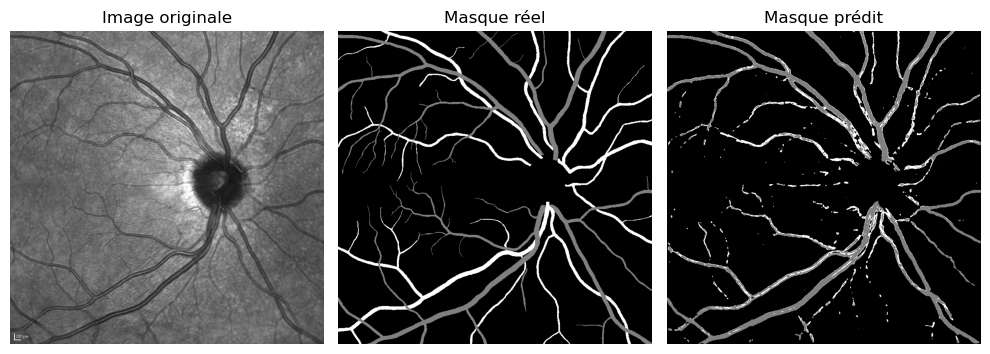

🖼️ Image 2 — Accuracy : 0.9256


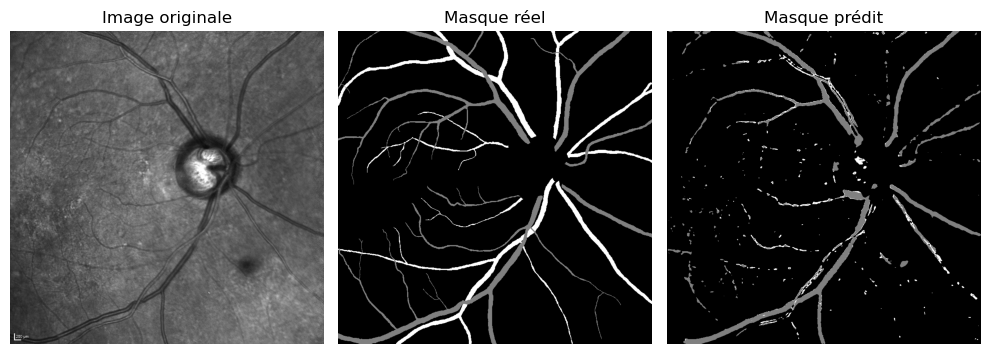

🖼️ Image 3 — Accuracy : 0.9146


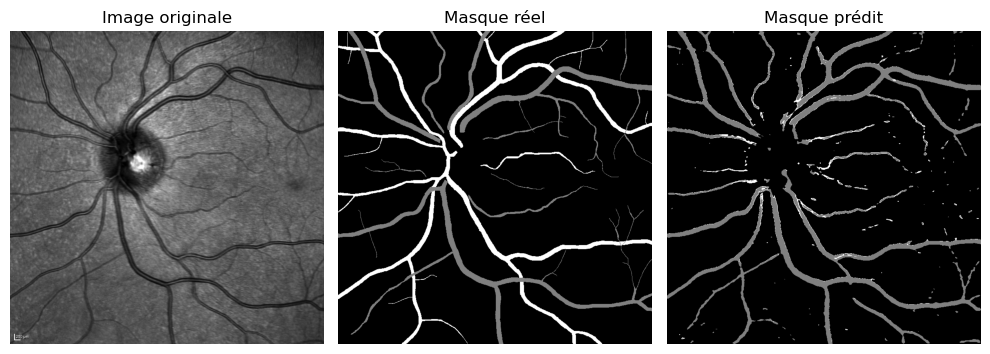

🖼️ Image 4 — Accuracy : 0.9183


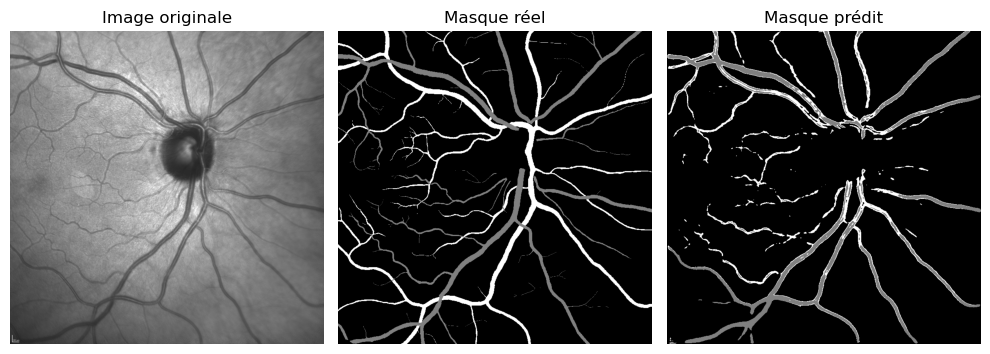

🖼️ Image 5 — Accuracy : 0.8602


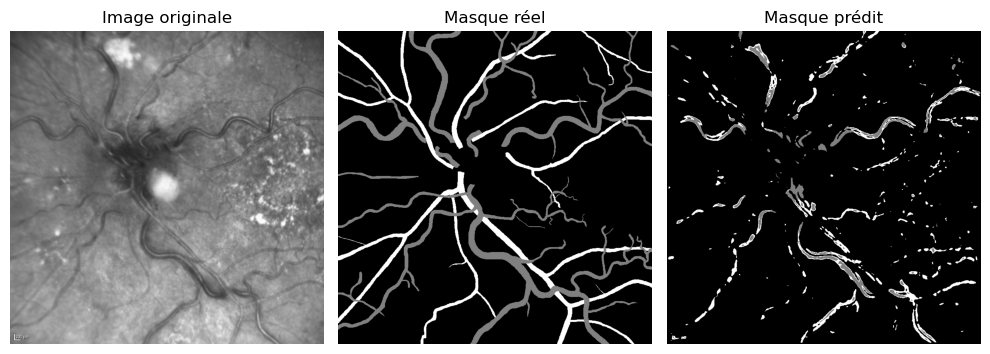


✅ Accuracy moyenne sur le jeu de validation : 0.9086


: 

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
total_correct = 0
total_pixels = 0

with torch.no_grad():
    img_index = 0  # compteur global des images

    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        # Boucle sur chaque image du batch
        for i in range(len(imgs)):
            pred = preds[i]
            mask = masks[i]

            # ===== Calcul de l’accuracy de cette image =====
            correct_pixels = (pred == mask).sum().item()
            total_pixels_img = mask.numel()
            acc_img = correct_pixels / total_pixels_img

            print(f"🖼️ Image {img_index+1} — Accuracy : {acc_img:.4f}")

            # ===== Affichage visuel =====
            fig, ax = plt.subplots(1, 3, figsize=(10, 4))
            ax[0].imshow(imgs[i].cpu().permute(1, 2, 0))
            ax[0].set_title("Image originale")
            ax[1].imshow(mask.cpu(), cmap="gray")
            ax[1].set_title("Masque réel")
            ax[2].imshow(pred.cpu(), cmap="gray")
            ax[2].set_title("Masque prédit")
            for a in ax:
                a.axis("off")
            plt.tight_layout()
            plt.show()

            # ===== Accumulateur global =====
            total_correct += correct_pixels
            total_pixels += total_pixels_img
            img_index += 1

# ===== Accuracy globale =====
val_acc = total_correct / total_pixels
print(f"\n✅ Accuracy moyenne sur le jeu de validation : {val_acc:.4f}")
